# 09_skim_lit

In [96]:
import zipfile
import urllib.request
import random
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import io
import string

from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys, calculate_results

import matplotlib.pylab as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.layers import TextVectorization
from keras import layers
from keras.layers import preprocessing
from keras.utils import plot_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
data_dir = "./data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['./data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 './data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 './data/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## visualizing 

In [3]:
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text_with_line_numbers(filename):
    """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
    input_lines = get_lines(filename)  # get all lines from filename
    abstract_lines = ""  # create an empty abstract
    abstract_samples = []  # create an empty list of abstracts

    # Loop through each line in target file
    for line in input_lines:
        if line.startswith("###"):  # check to see if line is an ID line
            abstract_id = line
            abstract_lines = ""  # reset abstract string
        elif line.isspace():  # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines(
            )  # split abstract into separate lines

            # Iterate through each line in abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(
                    abstract_line_split):
                line_data = {}  # create empty dict to store data from line
                target_text_split = abstract_line.split(
                    "\t")  # split target label from text
                line_data["target"] = target_text_split[0]  # get target label
                line_data["text"] = target_text_split[1].lower(
                )  # get target text and lower it
                line_data[
                    "line_number"] = abstract_line_number  # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(
                    abstract_line_split
                ) - 1  # how many total lines are in the abstract? (start from 0)
                abstract_samples.append(
                    line_data)  # add line data to abstract samples list

        else:  # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_samples


In [10]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [12]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [17]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [18]:
train_df[:15]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [32]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## making numeric labels (one-hot encoding)

In [49]:
one_hot_enocder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_enocder.fit_transform(
    train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_enocder.transform(
    val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_enocder.transform(
    test_df["target"].to_numpy().reshape(-1, 1))


In [23]:
tf.constant(train_labels_one_hot)

2023-02-22 13:56:02.736327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

## label encode labels

In [29]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(
    train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [30]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## model_0 naive bayes baseline

In [34]:
model_0 = Pipeline([
    ("tf_idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

model_0.fit(X=train_sentences, y=train_labels_encoded)


Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [35]:
# evaluation
model_0.score(X=val_sentences, y=val_labels_encoded)


0.7218323844829869

In [36]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [39]:
baseline_resultes = calculate_results(val_labels_encoded, baseline_preds)
baseline_resultes

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## tokenizing and embedding

he had some code that i didnt do to calculate the average sentence lengths. just use these numbers:

avg_sent_len = 26

95th_percentile = 55

In [41]:
max_tokens = 68000

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)


In [42]:
text_vectorizer.adapt(train_sentences)

In [43]:
# testing text_vecotrizer on random sentences
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")


Text:
the calibration analysis suggested that the original frs and the recalibrated frs overestimated the risk of chd in the japanese population .

Length of text: 22

Vectorized text:
[[    2  6697    85  1161    28     2  2135 12112     3     2 24876 12112
  10229     2    73     4  2741     5     2  1597   278     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


## how many words in vocab and most common words

In [44]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab), rct_20k_text_vocab[:5]


(64841, ['', '[UNK]', 'the', 'and', 'of'])

## embedding

In [47]:
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding",
)


In [48]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(
    f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n"
)
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the calibration analysis suggested that the original frs and the recalibrated frs overestimated the risk of chd in the japanese population .

Sentence after vectorization (before embedding):
[[    2  6697    85  1161    28     2  2135 12112     3     2 24876 12112
  10229     2    73     4  2741     5     2  1597   278     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.0412532  -0.0490819  -0.04794185 ...  0.01462771 -0.01965657
   -0.03160115]
  [-0.01709486 -0.01017039 -0.01959261 ... -0.03037887 -0.00753819
   -0.02738528]
  [-0.01293612 -0.00962698  0.01150991 ...  0.00202832 -0.02940555
    0.01770561]
  ...
  [-0.00773752 -0.01031874  0.04613134 ... -0.00856575  0.00866735
    0.02956858]
  [-0.00773752 -0.01031874  0.04613134 ... -0.00856575  0.00866735
    

## making datasets

In [56]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_labels_one_hot))

valid_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_labels_one_hot))

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [57]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## model_1 Conv1D with token embedding

In [58]:
inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vectors = text_vectorizer(inputs)  # vectorize text inputs
token_embeddings = token_embed(text_vectors)  # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same",
                  activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(
    x)  # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(
    loss=
    "categorical_crossentropy",  # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])


In [60]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [61]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 48s 83ms/step - loss: 0.9178 - accuracy: 0.6388 - val_loss: 0.6837 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 43s 76ms/step - loss: 0.6556 - accuracy: 0.7579 - val_loss: 0.6324 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 46s 83ms/step - loss: 0.6149 - accuracy: 0.7756 - val_loss: 0.5963 - val_accuracy: 0.7846


## model_2 feature extraction with pretrained token embedding

In [62]:
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="universal_sentence_encoder")


In [65]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [68]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 6s 12ms/step - loss: 0.7243 - accuracy: 0.7246 - val_loss: 0.7081 - val_accuracy: 0.7224
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6956 - accuracy: 0.7314 - val_loss: 0.6947 - val_accuracy: 0.7347
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6872 - accuracy: 0.7388 - val_loss: 0.6909 - val_accuracy: 0.7297


## model_3 Conv1D with character embeddings

In [70]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))


In [88]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [72]:
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

In [74]:
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [76]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [79]:
NUM_CHAR_TOKENS = len(alphabet) + 2  # + 2 for space and UNK
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [81]:
char_vectorizer.adapt(train_chars)

In [82]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab[:5]


(28, ['', '[UNK]', 'e', 't', 'i'])

## creating charc-level embedding layer

In [84]:
char_embed = layers.Embedding(
    input_dim=len(char_vocab),
    output_dim=25,  # from the paper
    mask_zero=True,
    name="char_embed")


## building a Conv1D model to fit charc embedding

In [85]:
inputs = layers.Input(shape=(1, ), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same",
                  activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [89]:
train_char_dataset = tf.data.Dataset.from_tensor_slices(
    (train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices(
    (val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

test_char_dataset = tf.data.Dataset.from_tensor_slices(
    (test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [90]:
model_3_history = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 11s 18ms/step - loss: 1.2814 - accuracy: 0.4866 - val_loss: 1.0822 - val_accuracy: 0.5848
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 1.0359 - accuracy: 0.5884 - val_loss: 0.9617 - val_accuracy: 0.6283
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.9443 - accuracy: 0.6311 - val_loss: 0.8821 - val_accuracy: 0.6659


## model_4 charc + token embedding

In [94]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# concatenate both above models
token_char_concat = layers.Concatenate(name="token_char_hybrid")(
    [token_model.output, char_model.output])

# creating output layers - adding dropout from the paper
combined_droupout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_droupout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [95]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

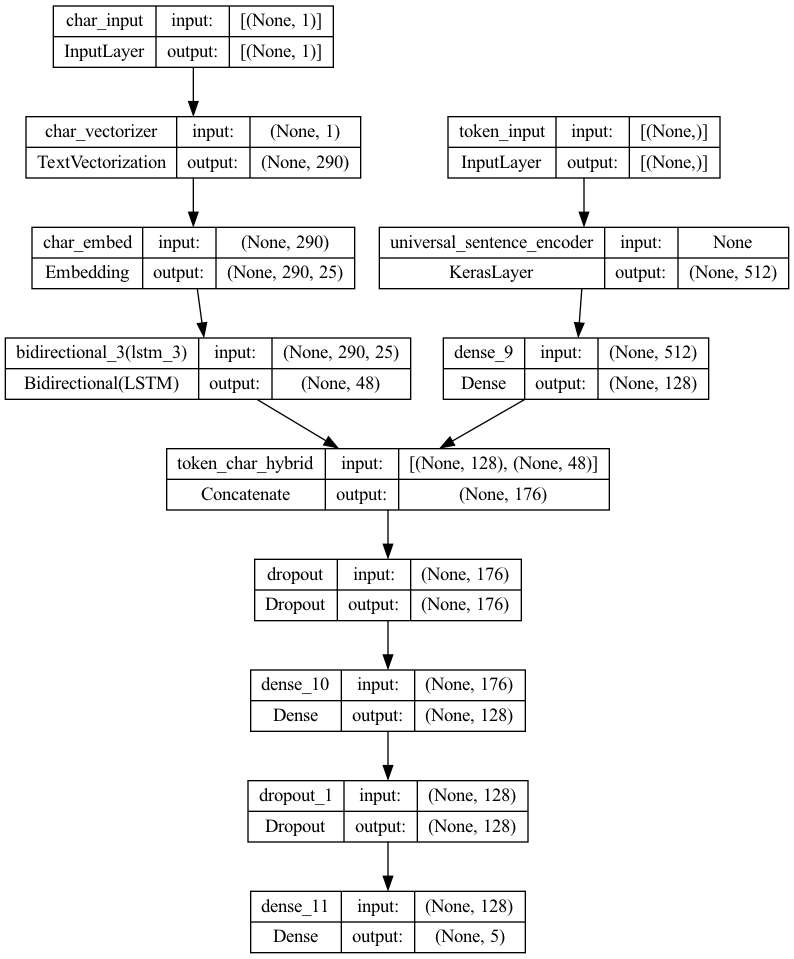

In [97]:
plot_model(model_4, show_shapes=True)


In [98]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## combining token and character data into a tf.data Dataset

In [99]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars))  # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(
    train_labels_one_hot)  # make labels
train_char_token_dataset = tf.data.Dataset.zip(
    (train_char_token_data,
     train_char_token_labels))  # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(
    tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip(
    (val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(
    tf.data.AUTOTUNE)


In [ ]:
model_4_history = model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
    epochs=3,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 100s 159ms/step - loss: 0.9820 - accuracy: 0.6105 - val_loss: 0.7853 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 82s 146ms/step - loss: 0.8076 - accuracy: 0.6877 - val_loss: 0.7211 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 82s 146ms/step - loss: 0.7790 - accuracy: 0.7017 - val_loss: 0.6966 - val_accuracy: 0.7387


## feature engineering 

In [105]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),
                                        depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),
                                      depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),
                                       depth=15)

train_line_numbers_one_hot[:3]

<tf.Tensor: shape=(3, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [109]:
np.percentile(train_df.total_lines, 98)

20.0

In [110]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),
                                       depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),
                                     depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),
                                      depth=20)


In [116]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
x = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,outputs=x)

total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_input")
y = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,outputs=y)

# concatenate both above models
combined_embeddings = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

z = layers.Dense(256,activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,total_lines_model.output,z])

# creating output layers - adding dropout from the paper
output_layer = layers.Dense(5,activation="softmax",name="output_layer")(tribrid_embeddings)

model_5 = tf.keras.Model(inputs=[line_number_model.inputs,total_lines_model.input,token_model.input,char_model.input],outputs=output_layer,name="model_5_tribrid_embedding")

In [117]:
model_5.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_i

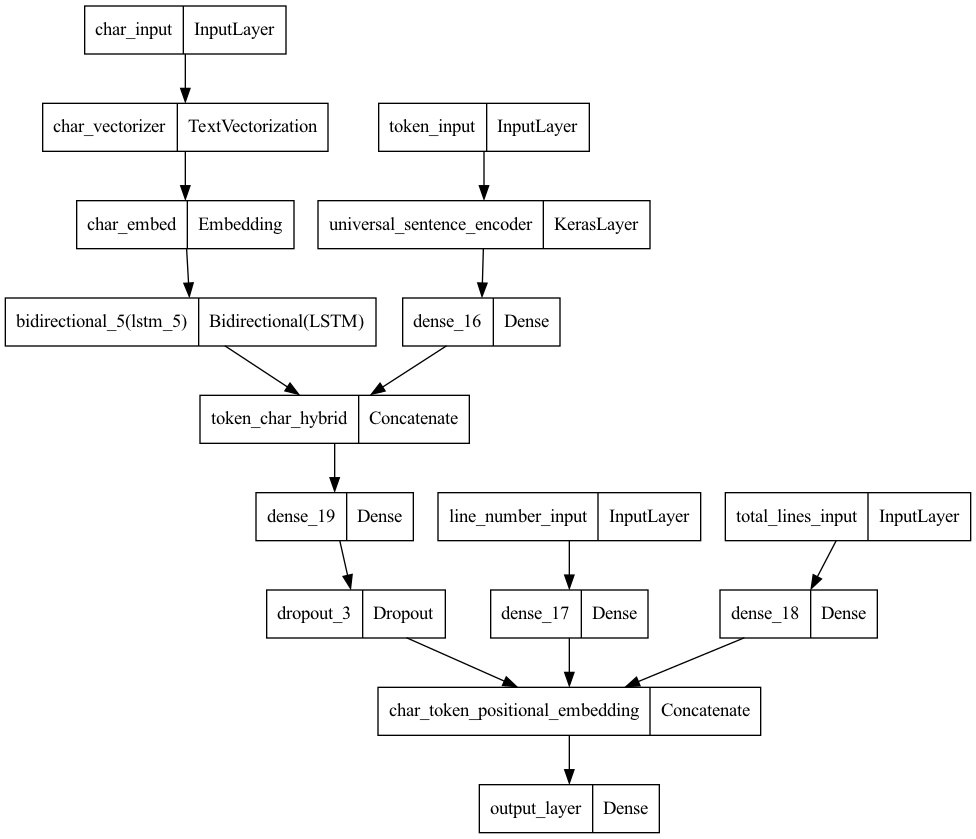

In [118]:
plot_model(model_5)

In [119]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"])

In [120]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,  # line numbers
    train_total_lines_one_hot,  # total lines
    train_sentences,  # train tokens
    train_chars))  # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(
    train_labels_one_hot)  # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip(
    (train_pos_char_token_data,
     train_pos_char_token_labels))  # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(
    tf.data.AUTOTUNE)  # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices(
    (val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences,
     val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(
    val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip(
    (val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(
    tf.data.AUTOTUNE)  # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [123]:
history_model_5 = model_5.fit(
    train_pos_char_token_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
    validation_data= val_pos_char_token_dataset,
    validation_steps=int(0.1*len(val_pos_char_token_dataset)),
)


Epoch 1/3
562/562 [==============================] - 94s 167ms/step - loss: 0.9661 - accuracy: 0.8146 - val_loss: 0.9552 - val_accuracy: 0.8205
Epoch 2/3
562/562 [==============================] - 84s 149ms/step - loss: 0.9501 - accuracy: 0.8286 - val_loss: 0.9352 - val_accuracy: 0.8358
Epoch 3/3
562/562 [==============================] - 86s 153ms/step - loss: 0.9410 - accuracy: 0.8298 - val_loss: 0.9313 - val_accuracy: 0.8384


In [124]:
model_5.save("./saves/09/model_5_skim_lit")

INFO:tensorflow:Assets written to: ./saves/09/model_5_skim_lit/assets


INFO:tensorflow:Assets written to: ./saves/09/model_5_skim_lit/assets


# Fin
#### so thats the end of that... it was super complex and very confusing. i didnt comment that much and copied some of his code just so i can keep up. i figured if i listened to him and his reasoning of why hes coding the way he is id learn more. so if you do find yourself confused just look at his jypnb online.
#### also his variable naming was SOOOOOOOOO WACK!!!!! a majority of my confusion was just because "oh wait what was this variable, oh what was that, what are you using this for?" hoooooooly man he sucks at naming... so ya fyi those names are not mine lol 